### The Delta Method

> CFO: What's our variation in churn this year?

> Data scientist: Our $\lambda$ value has been increasing, but $\rho$ is staying the same, so we should see-

> CFO: Our banana value is increasing?

We want to connect our parameters to business logic _and_ carry over variance in estimates. 

Example: It's silly to present a point estimate without confidence intervals (CIs), since arguably the CIs contains more useful information than a point estimate. 

We'll start with asking: what is the CI for the survival function, $S(t; \hat{\theta})$? 


We will use the **DELTA METHOD** to do this (bolded because it's awesome):

$$\text{Var}(f(\hat{\theta})) \approx \text{grad}(f)(\hat{\theta}) \cdot \text{Var}(\hat{\theta}) \cdot \text{grad}(f)(\hat{\theta}) ^ T $$

1. $f$ in our case is the survival function, $S$
2. We know $\text{Var}(\hat{\theta})$ (inverse of the Hessian)
3. Do we need to compute $\text{grad}(f)$ by hand? Heck no, use `autograd`

In [7]:
# seen all this...
%matplotlib inline
from autograd import numpy as np
from autograd import elementwise_grad, value_and_grad, hessian
from scipy.optimize import minimize

# N = 50 for this example
T = (np.random.exponential(size=50)/1.5) ** 2.3
E = np.random.binomial(1, 0.95, size=50)

def cumulative_hazard(params, t):
    lambda_, rho_ = params
    return (t / lambda_) ** rho_

hazard = elementwise_grad(cumulative_hazard, argnum=1)

def log_hazard(params, t):
    return np.log(hazard(params, t))

def log_likelihood(params, t, e):
    return np.sum(e * log_hazard(params, t)) - np.sum(cumulative_hazard(params, t))

def negative_log_likelihood(params, t, e):
    return -log_likelihood(params, t, e)

from autograd import value_and_grad

results = minimize(
        value_and_grad(negative_log_likelihood), 
        x0 = np.array([1.0, 1.0]),
        method=None, 
        args=(T, E),
        jac=True,
        bounds=((0.00001, None), (0.00001, None)))

estimates_ = results.x
H = hessian(negative_log_likelihood)(estimates_, T, E)
variance_matrix_ = np.linalg.inv(H)

In [2]:
from autograd import grad

def survival_function(params, t):
    return np.exp(-cumulative_hazard(params, t))

grad_sf = grad(survival_function)
grad_sf(estimates_, 5.0)

array([ 0.11163842, -0.24322003])

In [3]:
def variance_at_t(t):
    return grad_sf(estimates_, t) @ variance_matrix_ @ grad_sf(estimates_, t)

In [4]:
variance_at_t(5)

0.00036047601896770017

In [5]:
t = np.linspace(.001, 10, 100)

std_sf = np.sqrt(np.array([variance_at_t(_) for _ in t]))

Text(0.5, 1.0, 'Estimated survival function with CIs (Delta method)')

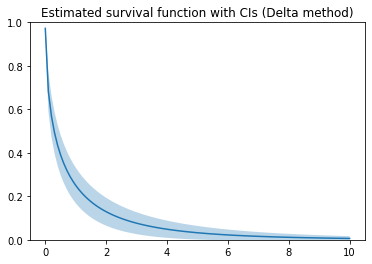

In [6]:
plt.plot(t, survival_function(estimates_, t))
plt.fill_between(t, 
                 y1=survival_function(estimates_, t) + 1.65 * std_sf, 
                 y2=survival_function(estimates_, t) - 1.65 * std_sf,
                 alpha=0.3
                )
plt.ylim(0, 1)
plt.title("Estimated survival function with CIs (Delta method)")

Next, we will explore a subscription service LTV example. Move to Part 7! 